<a href="https://colab.research.google.com/github/sznajder/Notebooks/blob/master/ML_LHC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to LHC data with ML and FastML: Tutorial




**Use GPU run time: Runtime --> Change Runtime**

In this tutorial, we explore a realistic LHC dataset composed of a **signal sample**: di-Higgs production

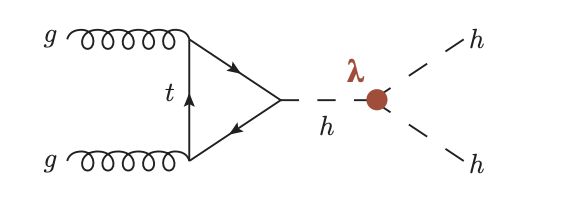

and several high cross-section **background processes** that dominate LHC datasets:

- **QCD multi-jet production**  
- **Top quark pair production** with fully hadronic decays  
- **W boson production** with hadronic decays  
- **Drell–Yan processes** (including $Z$ boson and other resonances)  

Our goal is to train machine learning models to classify these processes using **all reconstructed particles in each event**.  

Each particle comes with a set of features, including **kinematics, particle ID, and displacement from the primary vertex**. Consequently, the input tensors for our models have shape:

$$
[N_\text{events}, N_\text{particles}, N_\text{particle features}]
$$

We will train and compare three types of models:

---

### 1. Classic MLP

Uses flattened inputs for all particles in an event.  



### 2. DeepSet

This architecture introduces an **inductive bias that respects permutation symmetry**, meaning the output is invariant to the order of particles in the event.  

Each particle is first embedded individually through a shared function $\phi$:

$$
h_i = \phi(x_i), \quad i = 1, \dots, N_\text{particles}
$$

These embeddings are then **aggregated using a permutation-invariant operation**, typically summation, mean, or max:

$$
H = \rho\Big( \sum_{i=1}^{N_\text{particles}} h_i \Big)
$$

where $\rho$ is a function (often a small feed-forward network) that maps the aggregated embedding to the output, e.g., class probabilities.  



### 3. Transformer

In addition to respecting permutation symmetry, the Transformer allows for **particle interactions** through self-attention. Each particle’s representation is updated based on information from all other particles in the event.

In the self-attention mechanism:

$$
\text{Attention}(Q, K, V) = \text{softmax}\Big(\frac{Q K^\top}{\sqrt{d_k}}\Big) V
$$

where:

- $Q$ = queries derived from particle embeddings  
- $K$ = keys derived from particle embeddings  
- $V$ = values representing the information each particle carries  
- $d_k$ = dimension of the key vectors  

The matrix

$$
Q K^\top
$$

encodes the **interaction strength between every pair of particles**: it determines how much of particle $V_j$ (the information of particle $j$) is shared with particle $i$ (whose embedding forms the query $Q_i$).  

---

Throughout this tutorial, we justify architectural choices using principles from learning theory and provide references to relevant papers where appropriate.


In [ ]:
#boiler plate and helper functions

import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras import layers, models, regularizers
from keras.optimizers import Adam
from keras.optimizers.schedules import CosineDecay
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model
from keras import Model
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def plot_event_display(df):
  eta = np.array(df.iloc[0]['L1T_PFPart_Eta'])
  phi = np.array(df.iloc[0]['L1T_PFPart_Phi'])
  pt  = np.array(df.iloc[0]['L1T_PFPart_PT'])
  d0  = np.array(df.iloc[0]['L1T_PFPart_D0'])

  idx = np.argsort(pt)[-10:][::-1]
  eta = eta[idx]
  phi = phi[idx]
  pt  = pt[idx]
  d0  = d0[idx]

  R = 1.0
  d0_scale = 0.1
  x_end = np.sinh(eta)

  y_start = d0_scale * np.cos(phi)
  z_start = d0_scale * np.sin(phi)

  y_end = y_start + R * np.cos(phi)
  z_end = z_start + R * np.sin(phi)

  fig = plt.figure(figsize=(7,5), dpi=200)
  ax = fig.add_subplot(projection='3d')

  phi_grid = np.linspace(0, 2*np.pi, 100)
  x_grid = np.linspace(x_end.min()*1.2, x_end.max()*1.2, 100)
  Phi, Xg = np.meshgrid(phi_grid, x_grid)
  Yc = R * np.cos(Phi)
  Zc = R * np.sin(Phi)
  ax.plot_surface(Xg, Yc, Zc, alpha=0.1)
  for i, (xs, ys, zs, xe, ye, ze, et, ph, p) in enumerate(
      zip(np.zeros_like(x_end), y_start, z_start, x_end, y_end, z_end, eta, phi, pt)):
      ax.plot([xs, xe], [ys, ye], [zs, ze])
      if i == 0 or i == 1:
          ax.text(xe, ye, ze, f"[{p:.1f}, {et:.2f}, {ph:.2f}]", fontsize=8)

  ax.scatter(0, 0, 0, color='black', s=1)
  ax.text(0, 0, 0, "PV", color='black', fontsize=5, horizontalalignment='left', verticalalignment='bottom')

  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_zticks([])

  ax.set_xlabel("z ~ sinh(η)")
  ax.set_box_aspect((2,1,1))

  plt.tight_layout()
  plt.show()


def load_physics_dataset(files, features, labels=None, N_particles_max=50):
    events = []
    event_labels = []

    if labels is not None:
        if len(labels) == 1:
            labels = labels * len(files)
        else:
            assert len(labels) == len(files)

    for i, fname in enumerate(files):
        df = pd.read_parquet(fname)
        label = labels[i] if labels is not None else None

        for idx in range(len(df)):
            event_features = []

            for feat in features:
                arr = np.asarray(df[feat].iloc[idx], dtype=np.float32)

                if len(arr) > N_particles_max:
                    arr = arr[:N_particles_max]
                else:
                    padded = np.zeros(N_particles_max, dtype=np.float32)
                    padded[:len(arr)] = arr
                    arr = padded

                event_features.append(arr)

            event_tensor = np.stack(event_features, axis=1)
            events.append(event_tensor)

            if label is not None:
                event_labels.append(label)

    X = np.asarray(events, dtype=np.float32)
    y = np.asarray(event_labels, dtype=np.int64) if labels is not None else None

    return X, y



def preprocess_particles(X, feature_indices=[0,1,2,3], pt_index=0, eta_index=1, phi_index=2,
                         d0_index=3, eta_range=(-5.0, 5.0)):

    X_proc = X.copy()

    pt = X_proc[:, :, pt_index]
    pt_logged = np.log(pt + 1.0)
    pt_min, pt_max = pt_logged.min(), pt_logged.max()
    X_proc[:, :, pt_index] = (pt_logged - pt_min) / (pt_max - pt_min + 1e-8)

    eta = X_proc[:, :, eta_index]
    eta_min, eta_max = eta_range
    X_proc[:, :, eta_index] = (eta - eta_min) / (eta_max - eta_min)
    X_proc[:, :, eta_index] = np.clip(X_proc[:, :, eta_index], 0.0, 1.0)

    d0 = X_proc[:, :, d0_index]
    d0_min, d0_max = d0.min(), d0.max()
    X_proc[:, :, d0_index] = (d0 - d0_min) / (d0_max - d0_min + 1e-8)

    phi = X_proc[:, :, phi_index]
    phi_cos = np.cos(phi)
    phi_sin = np.sin(phi)

    X_proc = np.delete(X_proc, phi_index, axis=2)
    X_proc = np.concatenate([X_proc, phi_cos[..., np.newaxis], phi_sin[..., np.newaxis]], axis=2)

    return X_proc


def load_test_data(df, features, labels=None, N_particles_max=50):

    events = []

    if labels is not None:
        assert len(labels) == len(df), "Labels must match number of events"

    for idx, row in df.iterrows():
        event_features = []
        for feat in features:
            arr = np.asarray(row[feat], dtype=np.float32)
            if len(arr) > N_particles_max:
                arr = arr[:N_particles_max]
            else:
                padded = np.zeros(N_particles_max, dtype=np.float32)
                padded[:len(arr)] = arr
                arr = padded
            event_features.append(arr)
        event_tensor = np.stack(event_features, axis=1)  # shape (N_particles, N_features)
        events.append(event_tensor)

    X = np.asarray(events, dtype=np.float32)
    y = np.asarray(labels, dtype=np.int64) if labels is not None else None
    return X, y



In [ ]:
!gdown --folder 1QY2_dIBpnMJQYk9jva5L7pLWeH9zXitl --remaining-ok

Retrieving folder contents
Retrieving folder 17rOnkQBDrK6cBZZ89Eu6Fpl7h8kJOi8X hls4ml_models
Processing file 1BBD6WUyJljWZRw7IwKzHoPSKUejLkL-J deepset_defaulthls4ml.tar.gz
Processing file 1PxqdWEkelaY-7zigHlnn1pZ7QDUd-ZyX deepset_parallel.tar.gz
Processing file 1VE3ce68cB2Fs-x3Nnx56QDeIKpOtmob7 deepset_resource_rf2.tar.gz
Processing file 1_ft7-wTru_gOsPrHLq1XkjVSWJIOiKG9 deepset_resource_rf5.tar.gz
Processing file 1DhM1uOtFAch9Ullg71t8_VHpF9BP6iZN deepset_resource.tar.gz
Processing file 1dl8ImRZmQq0tfniECPRWeqW6TurK1tfb deepset_stream.tar.gz
Processing file 16kzfcPO6Ug53yhHcnbVgWPgas1szORNw hgq_deepset.tar.gz
Processing file 1wpiCRGqs6xb2pLdr5GMOUX5igYwxB9X5 DYJetsToLL_13TeV-madgraphMLM-pythia8.parquet
Processing file 1pI4Uyqt_SQ4RDnGbasrbL1W9BWrmKR1Q HH_4b.parquet
Processing file 1jot0g4rrCDDt5W1hxcAiDNzUOXQ4Acmm QCD_HT50toInf.parquet
Processing file 1E2WO08nXd9uv-qUF3kMFCIh0TTDyfqz4 test_labels.csv
Processing file 1tSobe7KdO5TDljrPxEaj5_Q2Qa0CVVk0 test.parquet
Processing file 1613q5d

In [ ]:
df_hh4b = pd.read_parquet("/content/ML_tutorial /HH_4b.parquet")

In [ ]:
df_hh4b.head()

,L1T_PFPart_PT,L1T_PFPart_Eta,L1T_PFPart_Phi,L1T_PFPart_PID,L1T_PFPart_Charge,L1T_PFPart_Mass,L1T_PFPart_D0,L1T_PFPart_DZ,L1T_PFPart_ErrorD0,L1T_PFPart_ErrorDZ,L1T_PFPart_fUniqueID,L1T_PFPart_PuppiW
0,"[41.75, 17.359375, 15.2421875, 14.125, 13.6406...","[0.5385742, -0.10809326, 0.57373047, -2.998046...","[-2.7363281, -1.1650391, -2.6894531, 1.6621094...","[-321.0, -13.0, 211.0, 0.0, -211.0, 0.0, -2212...","[-1.0, 1.0, 1.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0....","[0.49365234, 0.105651855, 0.13952637, -2.68220...","[-0.25097463, -0.13478903, 2.2364342, 0.0, 0.0...","[-51.531757, -52.59871, -54.065083, 0.0, 52.01...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[91247.0, 80808.0, 91277.0, 89143.0, 91267.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,"[16.578125, 12.984375, 11.984375, 11.3203125, ...","[-1.4384766, -3.4882812, -0.60839844, 0.796386...","[1.2460938, -1.9951172, -0.8144531, -0.4277343...","[13.0, 0.0, 22.0, 0.0, 321.0, -211.0, -211.0, ...","[-1.0, 0.0, 0.0, 0.0, 1.0, -1.0, -1.0, 1.0, -1...","[0.105651855, -2.682209e-06, 3.5762787e-07, -1...","[0.068535365, 0.0, 0.0, 0.0, -0.028661361, 0.1...","[13.898323, 0.0, 0.0, 0.0, 13.27427, 12.889426...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[75943.0, 83582.0, 89463.0, 85944.0, 85598.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,"[24.234375, 21.421875, 16.515625, 11.234375, 1...","[-0.49853516, 1.5410156, 3.2460938, -4.4648438...","[-0.69433594, -2.8808594, 1.3037109, 1.1074219...","[0.0, 22.0, 0.0, 0.0, 0.0, 211.0, 0.0, 0.0, -3...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, -1.0,...","[0.0, -6.556511e-07, 2.682209e-06, 0.0, 3.5762...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.02241477, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 56.19509, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[87838.0, 92107.0, 90094.0, 85492.0, 88430.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,"[23.53125, 21.53125, 19.515625, 18.296875, 17....","[2.0546875, 1.5869141, -1.2304688, 1.6103516, ...","[-2.0117188, 0.2602539, 2.8164062, 0.27563477,...","[0.0, 0.0, -211.0, 22.0, 0.0, 0.0, 22.0, 22.0,...","[0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 9.536743e-07, 0.13952637, 0.0, 1.3709068...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 13.2207985, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[94591.0, 94215.0, 93411.0, 98022.0, 95102.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,"[48.28125, 35.46875, 31.828125, 29.5625, 26.75...","[-0.8857422, 0.26953125, -0.93408203, -0.86035...","[-1.0107422, 1.2246094, -0.9794922, -1.0214844...","[211.0, 22.0, 0.0, 22.0, 0.0, -11.0, 211.0, -2...","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, -1.0, 0.0,...","[0.13952637, 0.0, -9.536743e-07, 6.556511e-07,...","[-0.0, 0.0, 0.0, 0.0, 0.0, -0.83604026, -0.0, ...","[9.584713, 0.0, 0.0, 0.0, 0.0, 10.715118, 9.58...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[95771.0, 100291.0, 95770.0, 100095.0, 95816.0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


Lets the top 10 most energetic particles produced in a ggF(HH-->4b) event.

$p_T$, $\eta$ , $\phi$ of particles is labeled.


You will also notice their trajectories originate from slightly different points, this is displacement from the Primary Vertex (PV)

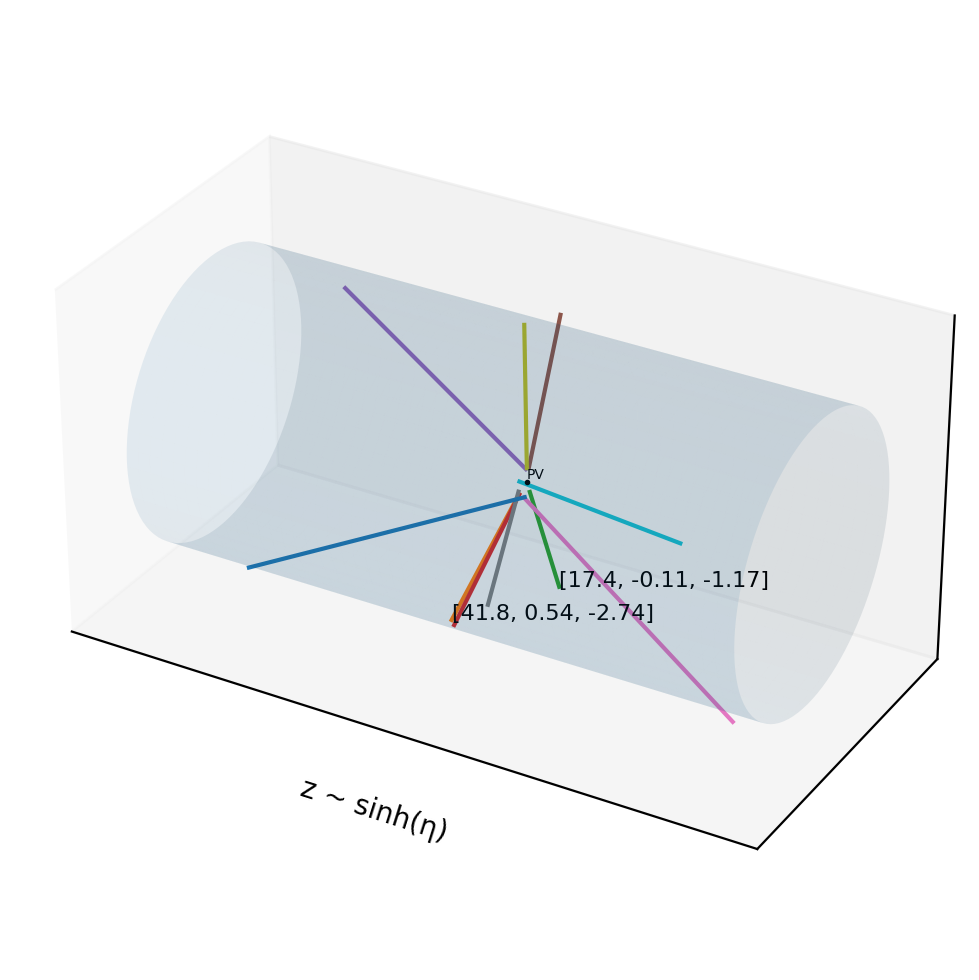

In [ ]:
plot_event_display(df_hh4b)

In [ ]:
files = [
    '/content/ML_tutorial /HH_4b.parquet',
    '/content/ML_tutorial /DYJetsToLL_13TeV-madgraphMLM-pythia8.parquet',
    '/content/ML_tutorial /QCD_HT50toInf.parquet',
    '/content/ML_tutorial /WJetsToLNu_13TeV-madgraphMLM-pythia8.parquet'
]

features = [            #The features per particle in the event, Kinematics + displacement from PV
    'L1T_PFPart_PT',
    'L1T_PFPart_Eta',
    'L1T_PFPart_Phi',
    'L1T_PFPart_D0'
]


labels = [1, 2, 0, 3]   # HH=1, DY=2, QCD=0, WJets=3

X, y = load_physics_dataset(
    files,
    features,
    labels=labels,
    N_particles_max=128
)

print(X.shape)  # (N total events, N particles per event, N features per particle)
print(y.shape)  # (N total events)


(230985, 128, 4)
(230985,)


In [ ]:
X_proc = preprocess_particles(X) #Here, we are normalising the input data to put features on the same scale. Because Phi is periodic, we encode as sine and cosine so we expand the feature dimension
print(X_proc.shape)

(230985, 128, 5)


In [ ]:

X_train, X_val, y_train, y_val = train_test_split(
    X_proc, y, test_size=0.1, random_state=42, stratify=y, shuffle = True
)


### Now lets train different types of models with varying Inductive Biases:

In [ ]:

#MLP


input_shape = X_train.shape[1:]
n_classes = len(set(y_train))


initial_lr = 1e-3
epochs = 20
steps_per_epoch = X_train.shape[0] // 512
lr_schedule = CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=epochs * steps_per_epoch,
    alpha=1e-4
)

optimizer = Adam(learning_rate=lr_schedule)

inputs = layers.Input(shape=input_shape)
x = layers.Flatten()(inputs)

x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
# Fundamental theorem of learning theory: High-D embedding space can make complex data linearly separable
x = layers.Dropout(0.1)(x)

x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x) #Weight decay
x = layers.Dropout(0.1)(x) #Skip connections

x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.1)(x)

x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.1)(x)

x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
# Disentangle features in high-D space, then compress to learn high-quality representations
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(n_classes, activation='softmax')(x)

mlp_model = models.Model(inputs, outputs)

mlp_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

from keras.callbacks import ModelCheckpoint

checkpoint_path = "mlp_best_model.h5"
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)


history = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,  # The ratio of learning rate to batch size controls the “temperature” of the optimiser: higher values promote exploration. Temperature also affects the geometry of the minima. Paper: https://openreview.net/references/pdf?id=S1UD-XWCZ
    shuffle=True,
    callbacks=[checkpoint_cb]
)

train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Final Train Accuracy: {train_acc:.3f}")
print(f"Final Validation Accuracy: {val_acc:.3f}")
print(f"Best model saved at: {checkpoint_path}")


In [ ]:
#DeepSet

input_shape = X_train.shape[1:]
n_classes = len(set(y_train))


initial_lr = 1e-3
epochs = 20
batch_size = 64
steps_per_epoch = X_train.shape[0] // batch_size
lr_schedule = CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=epochs * steps_per_epoch,
    alpha=1e-4
)
optimizer = Adam(learning_rate=lr_schedule)


inputs = layers.Input(shape=input_shape)

# Shared particle embedding (DeepSet Phi). Each particle is independently embedded by an MLP
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(inputs)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)

# Permutation-invariant aggregation
x = layers.GlobalAveragePooling1D()(x)

# Classifier (DeepSet Rho)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

deepset_model = models.Model(inputs, outputs)


deepset_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_path = "deepset_best_model.h5"
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)


history = deepset_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[checkpoint_cb]
)


train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

print(f"Final Train Accuracy: {train_acc:.3f}, Train Loss: {train_loss:.3f}")
print(f"Final Val Accuracy:   {val_acc:.3f}, Val Loss:   {val_loss:.3f}")
print(f"Best model saved at: {checkpoint_path}")


In [ ]:
import tensorflow as tf

class CLSToken(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        self.cls = self.add_weight(
            shape=(1, 1, self.embed_dim),
            initializer="zeros",
            trainable=True,
            name="cls_token_weight"
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return tf.tile(self.cls, [batch_size, 1, 1])

    def get_config(self):
        config = super().get_config()
        config.update({"embed_dim": self.embed_dim})
        return config
class ExtractCLS(layers.Layer):
    def call(self, inputs):
        return inputs[:, 0, :]

    def get_config(self):
        return super().get_config()


input_shape = X_train.shape[1:]
n_classes = len(set(y))

embed_dim = 128
num_heads = 4
ff_dim = 256
num_blocks = 2
dropout_rate = 0.1
epochs = 20
batch_size = 128
initial_lr = 1e-4

steps_per_epoch = X_train.shape[0] // batch_size
lr_schedule = CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=epochs * steps_per_epoch,
    alpha=1e-4
)
optimizer = Adam(learning_rate=lr_schedule)

inputs = layers.Input(shape=input_shape)

x = layers.Dense(embed_dim, kernel_regularizer=regularizers.l2(1e-4))(inputs)

# We will now learn the pooling operation rather than doing mean/sum.
cls_token = CLSToken(embed_dim, name="cls_token")(inputs)

x = layers.Concatenate(axis=1)([cls_token, x])

for _ in range(num_blocks):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(
        x, x
    )
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    ff = layers.Dense(ff_dim, activation='relu')(x)
    ff = layers.Dense(embed_dim)(ff)
    x = layers.Add()([x, ff])
    x = layers.LayerNormalization()(x)


cls_output = ExtractCLS()(x)

x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(cls_output)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

transformer_model = models.Model(inputs, outputs)

transformer_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_path = "transformer_best_model.keras"
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[checkpoint_cb]
)

train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Final Train Accuracy: {train_acc:.3f}")
print(f"Final Val Accuracy:   {val_acc:.3f}")
print(f"Best model saved at: {checkpoint_path}")

Epoch 1/20
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4471 - loss: 1.2129
Epoch 1: val_accuracy improved from -inf to 0.59782, saving model to transformer_best_model.keras
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 109s 61ms/step - accuracy: 0.4472 - loss: 1.2128 - val_accuracy: 0.5978 - val_loss: 0.9800
Epoch 2/20
  53/1625 ━━━━━━━━━━━━━━━━━━━━ 1:20 51ms/step - accuracy: 0.5810 - loss: 1.0123

KeyboardInterrupt: 

In [ ]:
df_test = pd.read_parquet("/content/ML_tutorial /test.parquet")

y_test = pd.read_csv("/content/ML_tutorial /test_labels.csv")['label'].values

X_test, y_test = load_test_data(df_test, features, labels=y_test, N_particles_max=128)

print(X_test.shape)  # (N_events, N_particles, N_features)
print(y_test.shape)  # (N_events,)

(80000, 128, 4)
(80000,)


In [ ]:
X_test = preprocess_particles(X_test)
print(X_test.shape)

(80000, 128, 5)


In [ ]:
def evaluate_model(model, X, y, model_name="Model"):
    y_pred = np.argmax(model.predict(X, batch_size=512), axis=1)

    acc = np.mean(y_pred == y)
    print(f"\n=== {model_name} ===")
    print(f"Test Accuracy: {acc:.3f}\n")

    print("Classification Report:")
    print(classification_report(y, y_pred, digits=3))

    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix:")
    print(cm)

    return acc, y_pred, cm

In [ ]:
mlp = load_model("mlp_best_model.h5")
deepset =  load_model("deepset_best_model.h5")
transformer = load_model("transformer_best_model.keras", custom_objects={'CLSToken': CLSToken, 'ExtractCLS': ExtractCLS})

In [ ]:
mlp_acc, mlp_pred, mlp_cm = evaluate_model(mlp, X_test, y_test, "MLP")

In [ ]:
deepset_acc, deepset_pred, deepset_cm = evaluate_model(deepset, X_test, y_test, "Deepset")

In [ ]:
transformer_acc, transformer_pred, transformer_cm = evaluate_model(transformer, X_test, y_test, "Transformer")

157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step

=== Transformer ===
Test Accuracy: 0.568

Classification Report:
              precision    recall  f1-score   support

           0      0.407     0.116     0.181     20000
           1      0.751     0.793     0.772     20000
           2      0.485     0.839     0.614     20000
           3      0.563     0.523     0.542     20000

    accuracy                          0.568     80000
   macro avg      0.552     0.568     0.527     80000
weighted avg      0.552     0.568     0.527     80000

Confusion Matrix:
[[ 2329  3378 10521  3772]
 [ 1563 15869   465  2103]
 [  747   246 16770  2237]
 [ 1077  1634  6838 10451]]


In [ ]:

mlp_embedding = Model(
    inputs=mlp.input,
    outputs=mlp.layers[-2].output
)

deepset_embedding = Model(
    inputs=deepset.input,
    outputs=deepset.layers[-2].output
)

transformer_embedding = Model(
    inputs=transformer.input,
    outputs=transformer.layers[-2].output
)



In [ ]:
mlp_embedding  = mlp_embedding.predict(X_test)


In [ ]:
deepset_embedding  = deepset_embedding.predict(X_test)

In [ ]:
transformer_embedding  = transformer_embedding.predict(X_test)

6497/6497 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step


In [ ]:
def plot_embeddings(embeddings, labels, title):
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(embeddings)
    plt.figure(figsize=(6,5))
    for cls in np.unique(labels):
        mask = labels == cls
        plt.scatter(emb_2d[mask,0], emb_2d[mask,1], label=f"Class {cls}", s=10, alpha=0.1)
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
plot_embeddings(mlp_embedding, y_train, "MLP Internal Representations")

In [ ]:
plot_embeddings(deepset_embedding, y_train, "DeepSet Internal Representations")

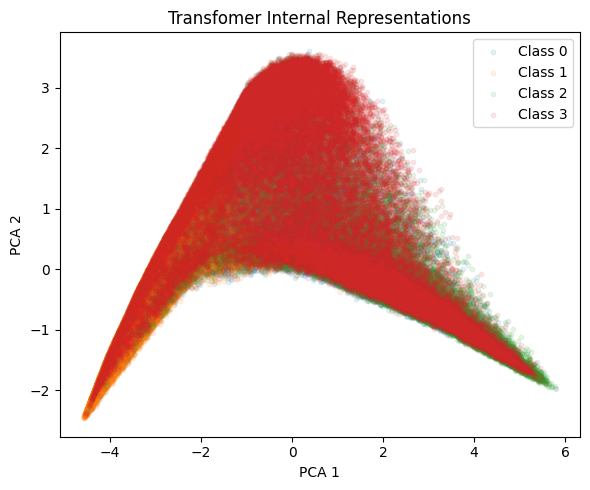

In [ ]:
plot_embeddings(transformer_embedding, y_train, "Transfomer Internal Representations")

Its now conventional wisdom that classification does not produce the best internal representations!

The representations are dependent on the task prior imposed.

For images, state-of-the-art is DINO-V3: https://arxiv.org/abs/2508.10104

Also applied in physics: https://arxiv.org/pdf/2512.01324

# hls4ml and synthezable models

In this section we will see how to perform a basic hls4ml conversion and highlight some of the key parameters from the slides.

Unfortunately we do not have access to the vivado tool chain (it is 100s GB and requires a licence) but indiviudal institutes will have access to vivado for your projects going forward.

The first thing we need to do is make our model ready for synthesis as very large models will not run. We would also, at this point, quantise our model either with a tool such as HGQ (seen before) or PQuant which will be seen later in the week. For now we will just perform a "post training quantization" of the model using hls4ml's quantizer just remember that this will not give optimal performance but the tools and tricks of using hls4ml will be using.

In trigger-like applications we often have to truncate the number of input candidates being used for downstream calculations because of the limitations of our processing chain, let's start with that

In [ ]:
files = [
    '/content/ML_tutorial /HH_4b.parquet',
    '/content/ML_tutorial /DYJetsToLL_13TeV-madgraphMLM-pythia8.parquet',
    '/content/ML_tutorial /QCD_HT50toInf.parquet',
    '/content/ML_tutorial /WJetsToLNu_13TeV-madgraphMLM-pythia8.parquet'
]

features = [
    'L1T_PFPart_PT',
    'L1T_PFPart_Eta',
    'L1T_PFPart_Phi',
    'L1T_PFPart_D0'
]


labels = [1, 2, 0, 3]   # HH=1, DY=2, QCD=0, WJets=3

X_s, y_s = load_physics_dataset(
    files,
    features,
    labels=labels,
    N_particles_max=16 # Truncate number of particles to 16 for FPGA model
)

print(X_s.shape)  # (N total events, N particles per event, N features per particle)
print(y_s.shape)  # (N total events)

(230985, 16, 4)
(230985,)


In [ ]:
X_proc_s = preprocess_particles(X_s) # re - preprocess input data with fewer candidates
print(X_proc_s.shape)

X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(
    X_proc_s, y_s, test_size=0.1, random_state=42, stratify=y_s, shuffle = True
)

(230985, 16, 5)


Now we can define a smaller version of our deepsets model, this time we will reduce the number of nodes per layer given we have fewer inputs to deal with. We will also remove the final softmax activation function as this will be implemented as a large look up table in our firmware and for downstream processing we don't really mind if our output is rescaled as a probability or not. We have to be slightly careful here and redefine our loss function as a standard cross entropy expects an output between 0 and 1. Thankfully all we need to do is tell the loss function to expect 'logits' rather than the class probability.

Later you can experiment with changing the number of layers in the network, what do you think will happen to the resources and the latency of the model?

In [ ]:
#SmallDeepSet

input_shape = X_train_s.shape[1:]
n_classes = len(set(y_train_s))


initial_lr = 1e-3
epochs = 20
batch_size = 64
steps_per_epoch = X_train_s.shape[0] // batch_size
lr_schedule = CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=epochs * steps_per_epoch,
    alpha=1e-4
)
optimizer = Adam(learning_rate=lr_schedule)


inputs = layers.Input(shape=input_shape)

# Shared particle embedding (DeepSet Phi)
x = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(1e-4),name='emb_1')(inputs)
x = layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(1e-4),name='emb_2')(x)
x = layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(1e-4),name='emb_3')(x)

# Permutation-invariant aggregation
x = layers.GlobalAveragePooling1D(name='Pool')(x)

# Classifier (DeepSet Rho)
x = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(1e-4),name='class_1')(x)
x = layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(1e-4),name='class_2')(x)
x = layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(1e-4),name='class_3')(x)
outputs = layers.Dense(n_classes, activation='linear',name='output')(x)

small_deepset_model = models.Model(inputs, outputs)


small_deepset_model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

checkpoint_path = "small_deepset_best_model.h5"
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)


history = small_deepset_model.fit(
    X_train_s, y_train_s,
    validation_data=(X_val_s, y_val_s),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[checkpoint_cb]
)


train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

print(f"Final Train Accuracy: {train_acc:.3f}, Train Loss: {train_loss:.3f}")
print(f"Final Val Accuracy:   {val_acc:.3f}, Val Loss:   {val_loss:.3f}")
print(f"Best model saved at: {checkpoint_path}")

Epoch 1/20
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4031 - loss: 1.2271
Epoch 1: val_accuracy improved from -inf to 0.52942, saving model to small_deepset_best_model.h5


3249/3249 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.4032 - loss: 1.2271 - val_accuracy: 0.5294 - val_loss: 1.0637
Epoch 2/20
3246/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5267 - loss: 1.0617
Epoch 2: val_accuracy improved from 0.52942 to 0.53816, saving model to small_deepset_best_model.h5


3249/3249 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5267 - loss: 1.0617 - val_accuracy: 0.5382 - val_loss: 1.0448
Epoch 3/20
3246/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5325 - loss: 1.0464
Epoch 3: val_accuracy did not improve from 0.53816
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5325 - loss: 1.0464 - val_accuracy: 0.5380 - val_loss: 1.0437
Epoch 4/20
3245/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5372 - loss: 1.0439
Epoch 4: val_accuracy did not improve from 0.53816
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.5372 - loss: 1.0439 - val_accuracy: 0.5218 - val_loss: 1.0659
Epoch 5/20
3231/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5396 - loss: 1.0411
Epoch 5: val_accuracy improved from 0.53816 to 0.54145, saving model to small_deepset_best_model.h5


3249/3249 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.5396 - loss: 1.0411 - val_accuracy: 0.5415 - val_loss: 1.0395
Epoch 6/20
3245/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5423 - loss: 1.0396
Epoch 6: val_accuracy improved from 0.54145 to 0.54721, saving model to small_deepset_best_model.h5


3249/3249 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5423 - loss: 1.0396 - val_accuracy: 0.5472 - val_loss: 1.0357
Epoch 7/20
3230/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5463 - loss: 1.0370
Epoch 7: val_accuracy improved from 0.54721 to 0.56111, saving model to small_deepset_best_model.h5


3249/3249 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5463 - loss: 1.0370 - val_accuracy: 0.5611 - val_loss: 1.0244
Epoch 8/20
3241/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5665 - loss: 1.0178
Epoch 8: val_accuracy improved from 0.56111 to 0.58154, saving model to small_deepset_best_model.h5


3249/3249 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5665 - loss: 1.0178 - val_accuracy: 0.5815 - val_loss: 0.9950
Epoch 9/20
3231/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5795 - loss: 0.9982
Epoch 9: val_accuracy improved from 0.58154 to 0.58288, saving model to small_deepset_best_model.h5


3249/3249 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5795 - loss: 0.9982 - val_accuracy: 0.5829 - val_loss: 0.9949
Epoch 10/20
3235/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5827 - loss: 0.9911
Epoch 10: val_accuracy improved from 0.58288 to 0.58730, saving model to small_deepset_best_model.h5


3249/3249 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5827 - loss: 0.9911 - val_accuracy: 0.5873 - val_loss: 0.9829
Epoch 11/20
3235/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5857 - loss: 0.9865
Epoch 11: val_accuracy improved from 0.58730 to 0.58803, saving model to small_deepset_best_model.h5


3249/3249 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5857 - loss: 0.9865 - val_accuracy: 0.5880 - val_loss: 0.9802
Epoch 12/20
3244/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5883 - loss: 0.9811
Epoch 12: val_accuracy improved from 0.58803 to 0.58929, saving model to small_deepset_best_model.h5


3249/3249 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5883 - loss: 0.9811 - val_accuracy: 0.5893 - val_loss: 0.9782
Epoch 13/20
3236/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5880 - loss: 0.9802
Epoch 13: val_accuracy improved from 0.58929 to 0.59132, saving model to small_deepset_best_model.h5


3249/3249 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5880 - loss: 0.9802 - val_accuracy: 0.5913 - val_loss: 0.9787
Epoch 14/20
3229/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5884 - loss: 0.9788
Epoch 14: val_accuracy improved from 0.59132 to 0.59141, saving model to small_deepset_best_model.h5


3249/3249 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5884 - loss: 0.9788 - val_accuracy: 0.5914 - val_loss: 0.9774
Epoch 15/20
3234/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5876 - loss: 0.9804
Epoch 15: val_accuracy improved from 0.59141 to 0.59206, saving model to small_deepset_best_model.h5


3249/3249 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5876 - loss: 0.9804 - val_accuracy: 0.5921 - val_loss: 0.9756
Epoch 16/20
3248/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5888 - loss: 0.9789
Epoch 16: val_accuracy did not improve from 0.59206
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5888 - loss: 0.9789 - val_accuracy: 0.5919 - val_loss: 0.9749
Epoch 17/20
3244/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5868 - loss: 0.9802
Epoch 17: val_accuracy did not improve from 0.59206
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5868 - loss: 0.9802 - val_accuracy: 0.5917 - val_loss: 0.9751
Epoch 18/20
3239/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5873 - loss: 0.9779
Epoch 18: val_accuracy did not improve from 0.59206
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5873 - loss: 0.9779 - val_accuracy: 0.5919 - val_loss: 0.9746
Epoch 19/20
3235/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5900 - loss: 0.9777
Epoch 19: 

3249/3249 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5899 - loss: 0.9777 - val_accuracy: 0.5922 - val_loss: 0.9746
Epoch 20/20
3237/3249 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5904 - loss: 0.9755
Epoch 20: val_accuracy did not improve from 0.59223
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5904 - loss: 0.9755 - val_accuracy: 0.5918 - val_loss: 0.9745
Final Train Accuracy: 0.588, Train Loss: 0.978
Final Val Accuracy:   0.592, Val Loss:   0.975
Best model saved at: small_deepset_best_model.h5


And truncate the test set

In [ ]:
X_test_s, y_test_s = load_test_data(df_test, features, labels=y_test, N_particles_max=16)

print(X_test_s.shape)  # (N_events, N_particles, N_features)
print(y_test_s.shape)  # (N_events,)

(80000, 16, 4)
(80000,)


In [ ]:
X_test_s = preprocess_particles(X_test_s)
print(X_test_s.shape)

(80000, 16, 5)


Load and evaluate the smaller model on the truncated test set. How does it compare to our full model on the full test set?

In [ ]:
small_deepset =  load_model("small_deepset_best_model.h5")

In [ ]:
small_deepset_acc, small_deepset_pred, small_deepset_cm = evaluate_model(small_deepset, X_test_s, y_test_s, "SmallDeepset")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

=== SmallDeepset ===
Test Accuracy: 0.554

Classification Report:
              precision    recall  f1-score   support

           0      0.381     0.110     0.170     20000
           1      0.748     0.755     0.752     20000
           2      0.469     0.865     0.609     20000
           3      0.567     0.488     0.525     20000

    accuracy                          0.554     80000
   macro avg      0.541     0.554     0.514     80000
weighted avg      0.541     0.554     0.514     80000

Confusion Matrix:
[[ 2194  3137 11354  3315]
 [ 1751 15101   728  2420]
 [  726   262 17296  1716]
 [ 1090  1678  7465  9767]]


Now lets get started on the hls4ml project

In [ ]:
!pip install -q hls4ml[profiling]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 56.5 MB/s eta 0:00:00


We will start with a minimum working example

In [ ]:
import hls4ml


config = hls4ml.utils.config_from_keras_model(small_deepset, granularity='model', backend='Vitis')
print("-----------------------------------")
print("Configuration")
print(config)
print("-----------------------------------")
deepset_hls_model = hls4ml.converters.convert_from_keras_model(
    small_deepset,
    hls_config=config,
    backend='Vitis',
    output_dir='/content/ML_tutorial /deepset_defaulthls4ml/hls4ml_prj',
    part='xcu250-figd2104-2L-e'
)

deepset_hls_model.compile()

-----------------------------------
Configuration
{'Model': {'Precision': {'default': 'fixed<16,6>'}, 'ReuseFactor': 1, 'Strategy': 'Latency', 'BramFactor': 1000000000, 'TraceOutput': False}}
-----------------------------------


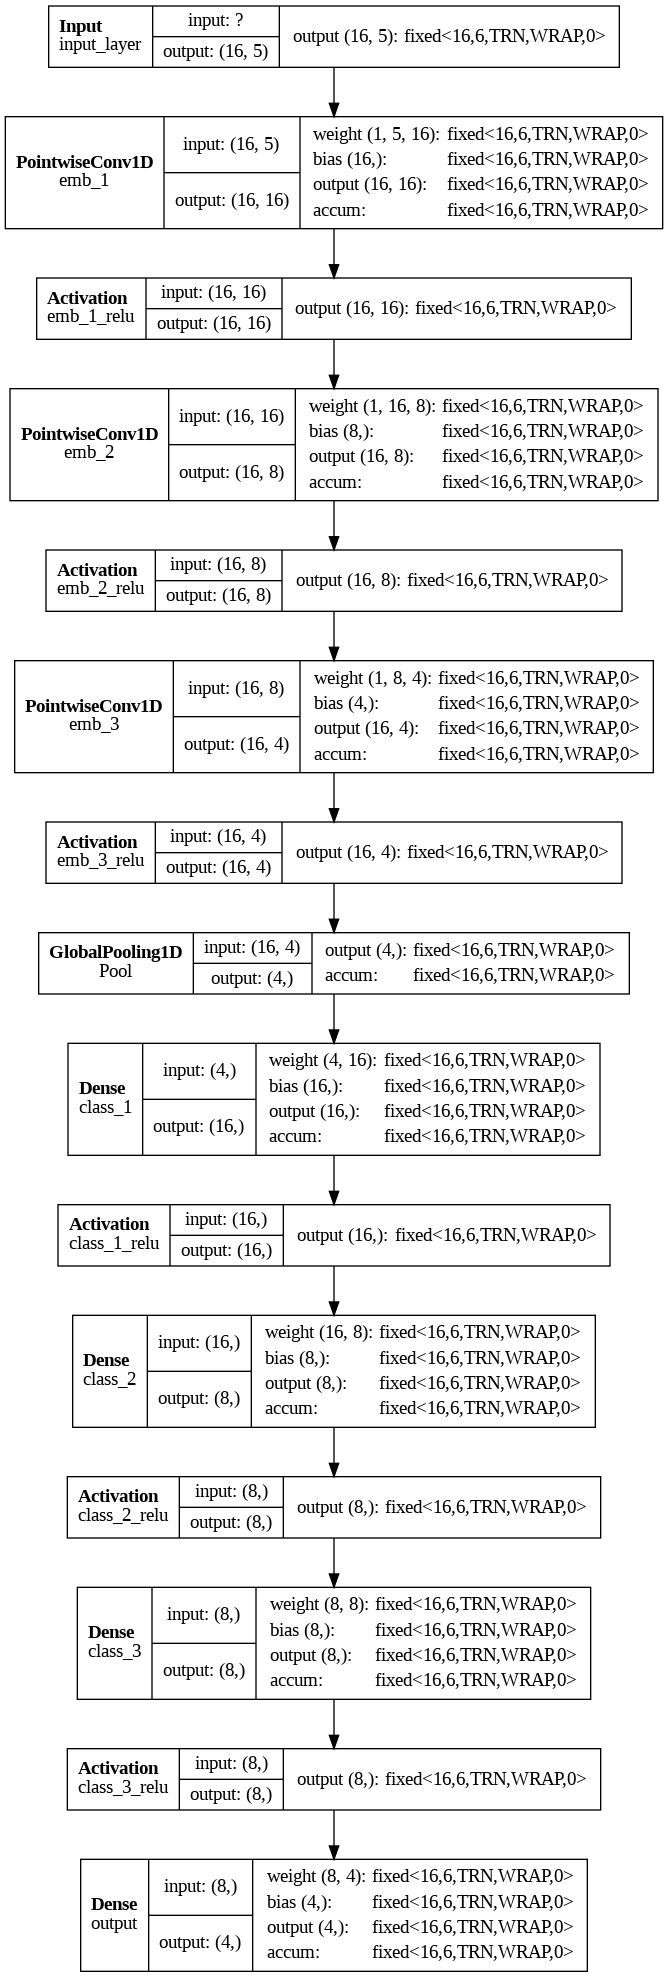

In [ ]:
hls4ml.utils.plot_model(deepset_hls_model, show_shapes=True, show_precision=True, to_file=None)

This model has undergone a "post-training quantisation" with the quantisation set to the hls4ml default ```ap_fixed<16,6>``` we can see what this has done to model performance:





=== hls deepset ap_fixed<16,6> ===
Test Accuracy: 0.555

Classification Report:
              precision    recall  f1-score   support

           0      0.407     0.122     0.187      2549
           1      0.741     0.759     0.750      2422
           2      0.465     0.869     0.606      2500
           3      0.588     0.485     0.531      2529

    accuracy                          0.555     10000
   macro avg      0.550     0.559     0.519     10000
weighted avg      0.548     0.555     0.515     10000

Confusion Matrix:
[[ 310  418 1439  382]
 [ 221 1838   95  268]
 [  85   34 2172  209]
 [ 146  192  965 1226]]
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

=== floating deepset ===
Test Accuracy: 0.556

Classification Report:
              precision    recall  f1-score   support

           0      0.418     0.120     0.186      2549
           1      0.740     0.761     0.750      2422
           2      0.469     0.866     0.608      2500
           3      0.579     0.495     0.534 

<Figure size 640x480 with 0 Axes>

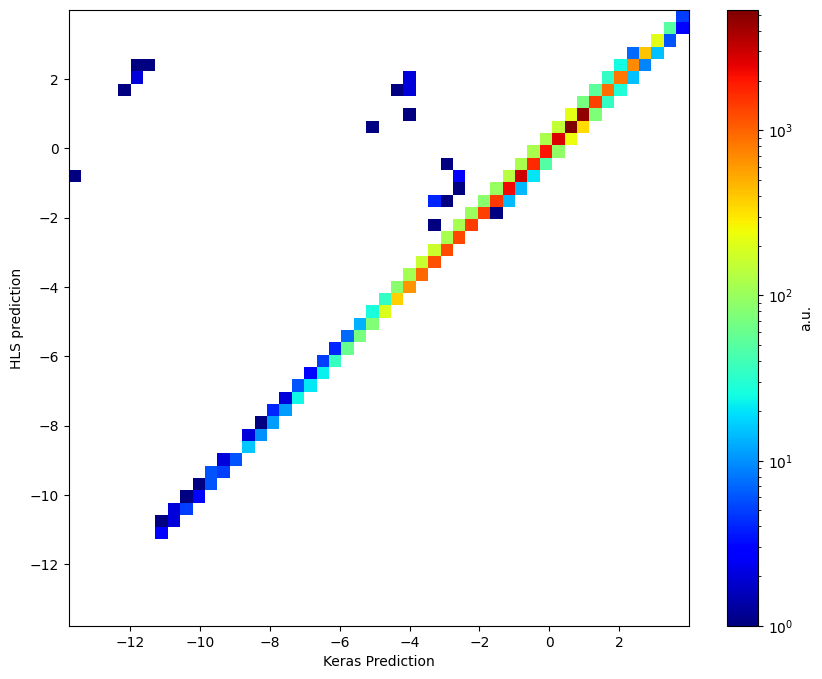

In [ ]:
import matplotlib

max_events = 10000
y_out_hls = deepset_hls_model.predict(np.ascontiguousarray(X_test_s[0:max_events]))
y_pred_hls = np.argmax(y_out_hls,axis=1)


acc = np.mean(y_pred_hls == y_test_s[0:max_events])
print("\n=== hls deepset ap_fixed<16,6> ===")
print(f"Test Accuracy: {acc:.3f}\n")

print("Classification Report:")
print(classification_report(y_test_s[0:max_events], y_pred_hls, digits=3))

cm = confusion_matrix(y_test_s[0:max_events], y_pred_hls)
print("Confusion Matrix:")
print(cm)

y_out = small_deepset.predict(np.ascontiguousarray(X_test_s[0:max_events]))
y_pred = np.argmax(y_out, axis=1)
acc = np.mean(y_pred == y_test_s[0:max_events])
print("\n=== floating deepset ===")
print(f"Test Accuracy: {acc:.3f}\n")

print("Classification Report:")
print(classification_report(y_test_s[0:max_events], y_pred, digits=3))

cm = confusion_matrix(y_test_s[0:max_events], y_pred)
print("Confusion Matrix:")
print(cm)


plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(10,8))
min_x = min(np.amin(y_out_hls.flatten()), np.amin(y_out.flatten()))
max_x = max(np.amax(y_out_hls.flatten()), np.amax(y_out.flatten()))
hist2d = ax.hist2d(y_out.flatten(), y_out_hls.flatten(), range=((min_x,max_x), (min_x,max_x)), bins=50, cmap='jet',norm=matplotlib.colors.LogNorm())
ax.set_xlabel('Keras Prediction')
ax.set_ylabel('HLS prediction')
cbar = plt.colorbar(hist2d[3], ax=ax)
cbar.set_label('a.u.')
plt.show()

In general the post training quantization hasn't broken the model but there are still outliers where the quantisation has forced a weight to zero. If we increase the precision what happens? If we decrease the precision what happens?

We can change this global model quantisation with:

```config['Model']['Precision'] = 'ap_fixed<15,5>'```


We can also change specific layers in the model manually, but only if we first set the "granularity" of the model to 'name' first with
```
config = hls4ml.utils.config_from_keras_model(small_deepset, granularity='name', backend='Vitis')
config['LayerName']['emb_1']['Precision']['weight'] = 'ap_fixed<8,2>'
config['LayerName']['output']['Precision']['result'] = 'fixed<16,6,RND,SAT>'
```

Normally we can rely on the automatic quantisation performed by hls4ml so changing specific layers is not needed. We may want to set the input or output precision if we are plugging in the network into a wider FW block where the input and output precisions are set and we don't want to change wrapper code every time we update a model

You can see the impact of post training quantisation on the model but there are better methods for model quantisation , e.g. setting model quantisation at training time so that the model learns weights within a certain bit range or allowing the quantisation of a weight to be a trainable parameter which you will see later in the High Granularity Quantisation tutorial.


We unfortunately can't run the ```deepset_hls_model.build()``` command here but this way of working where we train a model on one system and then perform the synthesis on another is very common. Your model, if it is large or you have done a large hyperparameter sweep is typically trained on a GPU but the synthesis which is CPU clock speed and RAM limited would be performed on a dedicated PC. To do this you would transfer the ```deepset``` directory to the other PC and perform the ```vitis-run --mode hls --tcl build_prj.tcl``` command.

We will see the output of that command in a bit but first let's look through the output of the hls4ml compile.

In ```ML_tutorial/deepset/hls4ml_prj```  we now have the hls4ml project and we can see what hls4ml has done. Let's take a quick look in ```hls4ml_prj/firmware/myproject.h```



```
#ifndef MYPROJECT_H_
#define MYPROJECT_H_

#include "ap_fixed.h"
#include "ap_int.h"
#include "hls_stream.h"

#include "defines.h"


// Prototype of top level function for C-synthesis
void myproject(
    input_t input_layer_2[16*5],
    result_t layer15_out[4]
);

// hls-fpga-machine-learning insert emulator-defines


#endif
```



Here we can see our inputs, 16 candidates * 5 features and the result 4 output classes. ```myproject.cpp``` shows us each layer definition in turn. If we look in defines we can see how each datatype for each layer has been defined as this ```ap_fixed<16,6>``` the default for hls4ml.


Also within the hls4ml_prj we have the ```build_prj.tcl``` which we can use to build the HLS project standalone using vitis and the ```build_opt.tcl```

```
array set opt {
    reset      0 # reset the project, remove any previous runs
    csim       1 # run c simulation
    synth      1 # run c synthesis
    cosim      1 # run co-sim
    validation 1 # run a comparison of csim and cosim
    export     0 # package output as a standalone packge, also run standalone place-and-route
    vsynth     0 # run vivado synth (more believable resource estimates)
    fifo_opt   0 # Run buffer depth optimisation with io_stream implementations
}
```

Where we control what hls builds

The output of the vitis build for this model can be found [here](https://drive.google.com/file/d/1BBD6WUyJljWZRw7IwKzHoPSKUejLkL-J/view?usp=drive_link)

We can see from the csynth results (```deepset_defaulthls4ml/hls4ml_prj/myproject_prj/solution1/syn/report/myproject_csynth.rpt```) that our initiation interval is 16 which makes sense if we think about what our model is doing, it is taking each of our 16 input candidates and running the same set of dense layers over them which are then combined with the global average pooling.

Say we want our initiation interval to be 1, this is standard for fully pipelined firmware where we have constant data coming in and we need to be able to process it as soon as it comes in. To do this we need to tell the hls4ml project that we want each of our intial embedding dense layers to be performed in parallel for all of our inputs, so let's set the parallelization factor of these layers to the number of parallel versions of that FW. In order to do layer by layer config we must also set the "granularity" of the hlsml config to "name"

In [ ]:
config = hls4ml.utils.config_from_keras_model(small_deepset, granularity='name', backend='Vitis')

config['LayerName']['emb_1']['ParallelizationFactor'] = 16 # Set the first 3 layers to be parallel. Note the names are what we set in the model definition,
config['LayerName']['emb_2']['ParallelizationFactor'] = 16
config['LayerName']['emb_3']['ParallelizationFactor'] = 16

print("-----------------------------------")
print("Configuration")
print(config)
print("-----------------------------------")
deepset_hls_model = hls4ml.converters.convert_from_keras_model(
    small_deepset,
    hls_config=config,
    backend='Vitis',
    output_dir='/content/ML_tutorial /deepset_parallel/hls4ml_prj',
    part='xcu250-figd2104-2L-e'
)

deepset_hls_model.compile()

Take a look in the built model found [here](https://drive.google.com/file/d/1PxqdWEkelaY-7zigHlnn1pZ7QDUd-ZyX/view?usp=drive_link)


Looking at the csynth report and you can see that we now have a model with an II=1 and a low latency. But we can see the resources, especially the DSPs have blown up which is expected as we have now 16 copies of the same firmware performing the calculations.


If II=1 and low latency is not needed we can consider a different strategy. Let's try the resource strategy

In [ ]:
config = hls4ml.utils.config_from_keras_model(small_deepset, granularity='model', backend='Vitis')
config['Model']['Strategy'] = 'Resource'

print("-----------------------------------")
print("Configuration")
print(config)
print("-----------------------------------")
deepset_hls_model = hls4ml.converters.convert_from_keras_model(
    small_deepset,
    hls_config=config,
    backend='Vitis',
    output_dir='/content/ML_tutorial /deepset_resource/hls4ml_prj',
    part='xcu250-figd2104-2L-e'
)

deepset_hls_model.compile()

The built model is [here](https://drive.google.com/file/d/1DhM1uOtFAch9Ullg71t8_VHpF9BP6iZN/view?usp=drive_link)

What is different about the resources and the latency?

There are some more toggles we can play with. The first is how the data is entered into the model, previously it is the default "io_parallel" but what happpens when we use "io_type='io_stream'" in the model config? The results are [here](https://drive.google.com/file/d/1dl8ImRZmQq0tfniECPRWeqW6TurK1tfb/view?usp=drive_link)

Finally we can consider changing the reuse factor of the model with ```config['Model']['ReuseFactor'] = 2``` the results of that build are [here](https://drive.google.com/file/d/1VE3ce68cB2Fs-x3Nnx56QDeIKpOtmob7/view?usp=drive_link) and a reuse factor of 5 [here](https://drive.google.com/file/d/1_ft7-wTru_gOsPrHLq1XkjVSWJIOiKG9/view?usp=drive_link)


What is the difference between the resources used by these models and the default hls4ml setup, what has caused these differences?

# HGQ sneak peak


In [ ]:
!pip install -q hgq2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 42.3 MB/s eta 0:00:00


In [ ]:
from hgq.layers import QDense
from hgq.config import LayerConfigScope, QuantizerConfigScope, QuantizerConfig
from hgq.regularizers import MonoL1
from hgq.utils.sugar import FreeEBOPs, BetaScheduler, ParetoFront

from math import cos, pi

In [ ]:
input_shape = X_train_s.shape[1:]
n_classes = len(set(y_train_s))

scope0 = QuantizerConfigScope(default_q_type='kbi',
                              place='datalane',
                              k0=1,
                              b0=3,
                              overflow_mode='sat_sym',
                              i0=0
                              )

scope1 = QuantizerConfigScope(default_q_type='kif',
                              place='datalane',
                              overflow_mode='wrap',
                              f0=3,
                              i0=3,
                              k0=0)


with scope0, scope1:

    iq_conf = QuantizerConfig(k0=1,place='datalane')
    oq_conf = QuantizerConfig(k0=1,place='datalane',fr=MonoL1(1e-3))


    inputs = layers.Input(shape=input_shape)
    # Shared particle embedding (DeepSet Phi)
    x = QDense(16, parallelization_factor=16, iq_conf=iq_conf,activation='relu')(inputs)
    x = QDense(8, parallelization_factor=16, activation='relu')(x)
    x = QDense(4, parallelization_factor=16, activation='relu')(x)

    # Permutation-invariant aggregation
    x = layers.GlobalAveragePooling1D()(x)

    # Classifier (DeepSet Rho)
    x = QDense(16, activation='relu')(x)
    x = QDense(8, activation='relu')(x)
    x = QDense(8, activation='relu')(x)
    outputs = QDense(n_classes, activation='linear',oq_conf=oq_conf)(x)

    hgq_deepset_model = models.Model(inputs, outputs)

In [ ]:
initial_lr = 1e-3
epochs = 10
batch_size = 64
steps_per_epoch = X_train.shape[0] // batch_size

beta_sched = BetaScheduler(lambda ep:3e-7 * 100 ** (ep/10000))

pareto = ParetoFront('/tmp/ckpts', ['val_accuracy', 'ebops'], [1,-1])

callbacks = [
            FreeEBOPs(),
            beta_sched,
            pareto
        ]

optimizer = Adam(learning_rate=initial_lr)

hgq_deepset_model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)



history = hgq_deepset_model.fit(
    X_train_s, y_train_s,
    validation_data=(X_val_s, y_val_s),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    callbacks=callbacks
)

train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

print(f"Final Train Accuracy: {train_acc:.3f}, Train Loss: {train_loss:.3f}")
print(f"Final Val Accuracy:   {val_acc:.3f}, Val Loss:   {val_loss:.3f}")


Epoch 1/100
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - accuracy: 0.5883 - loss: 0.9732 - val_accuracy: 0.5923 - val_loss: 0.9588 - ebops: 18517.0000 - beta: 3.0000e-07
Epoch 2/100
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.5880 - loss: 0.9725 - val_accuracy: 0.5909 - val_loss: 0.9629 - ebops: 18300.0000 - beta: 3.0014e-07
Epoch 3/100
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.5875 - loss: 0.9741 - val_accuracy: 0.5921 - val_loss: 0.9613 - ebops: 18325.0000 - beta: 3.0028e-07
Epoch 4/100
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.5863 - loss: 0.9759 - val_accuracy: 0.5945 - val_loss: 0.9596 - ebops: 17941.0000 - beta: 3.0041e-07
Epoch 5/100
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.5895 - loss: 0.9707 - val_accuracy: 0.5931 - val_loss: 0.9596 - ebops: 18336.0000 - beta: 3.0055e-07
Epoch 6/100
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.5871 - loss: 0.9716 - val_accuracy: 0.5922 - val_loss: 0.9593 - ebops: 1770

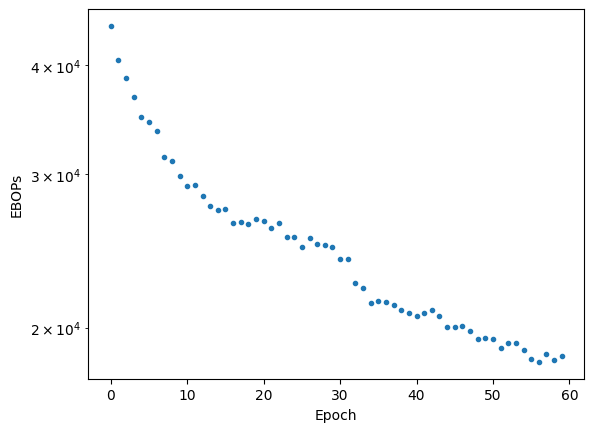

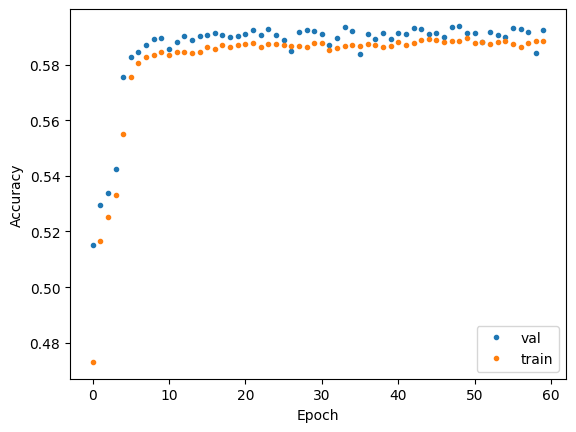

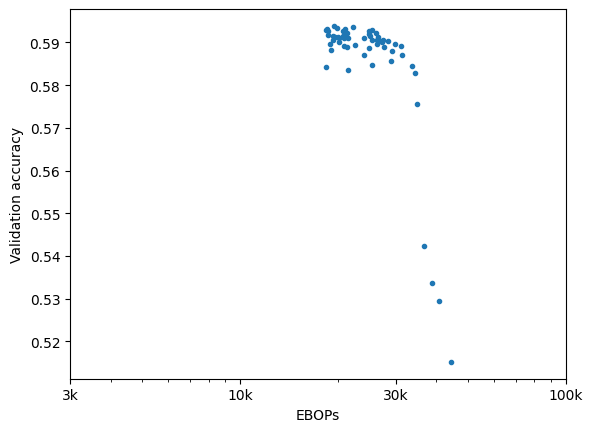

In [ ]:
plt.plot(history.history['ebops'], '.')
plt.ylabel('EBOPs')
plt.yscale('log')
plt.xlabel('Epoch')
plt.show()

plt.plot(history.history['val_accuracy'], '.', label='val')
plt.plot(history.history['accuracy'], '.', label='train')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(history.history['ebops'], history.history['val_accuracy'], '.')
plt.xscale('log')
plt.xlabel('EBOPs')
plt.ylabel('Validation accuracy')
plt.xticks([3000, 10000, 30000, 100000], ['3k', '10k', '30k', '100k'])
plt.show()

hgq_deepset_model.load_weights(pareto.paths[-1])
hgq_deepset_model.save("hgq_deepset_best_model.h5")

In [ ]:
hgq_deepset =  load_model("hgq_deepset_best_model.h5")

config={'Model': {'Strategy': 'latency', 'ReuseFactor': 1, 'Precision': 'fixed<16,5>'}}

print("-----------------------------------")
print("Configuration")
print(config)
print("-----------------------------------")
hgq_deepset_hls_model = hls4ml.converters.convert_from_keras_model(
    hgq_deepset,
    hls_config=config,
    backend='Vitis',
    output_dir='hgq_deepset/hls4ml_prj',
    part='xcu250-figd2104-2L-e',
)


hls4ml.utils.plot_model(hgq_deepset_hls_model, show_shapes=True, show_precision=True, to_file=None)
hgq_deepset_hls_model.compile()

-----------------------------------
Configuration
{'Model': {'Strategy': 'latency', 'ReuseFactor': 1, 'Precision': 'fixed<16,5>'}}
-----------------------------------



=== hls deepset ap_fixed<16,6> ===
Test Accuracy: 0.560

Classification Report:
              precision    recall  f1-score   support

           0      0.401     0.113     0.176      2549
           1      0.736     0.769     0.752      2422
           2      0.481     0.847     0.613      2500
           3      0.569     0.527     0.547      2529

    accuracy                          0.560     10000
   macro avg      0.546     0.564     0.522     10000
weighted avg      0.544     0.560     0.519     10000

Confusion Matrix:
[[ 288  449 1340  472]
 [ 194 1862   80  286]
 [  95   35 2117  253]
 [ 142  185  868 1334]]
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

=== floating deepset ===
Test Accuracy: 0.556

Classification Report:
              precision    recall  f1-score   support

           0      0.418     0.120     0.186      2549
           1      0.740     0.761     0.750      2422
           2      0.469     0.866     0.608      2500
           3      0.579     0.495     0.534 

<Figure size 640x480 with 0 Axes>

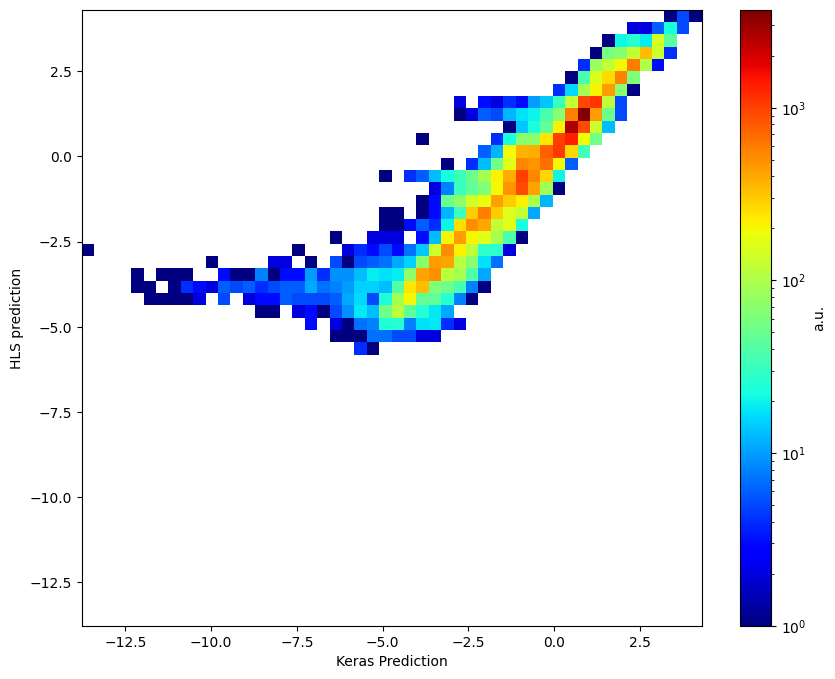

In [ ]:
import matplotlib

max_events = 10000
y_out_hls = hgq_deepset_hls_model.predict(np.ascontiguousarray(X_test_s[0:max_events]))
y_pred_hls = np.argmax(y_out_hls,axis=1)


acc = np.mean(y_pred_hls == y_test_s[0:max_events])
print("\n=== hls deepset ap_fixed<16,6> ===")
print(f"Test Accuracy: {acc:.3f}\n")

print("Classification Report:")
print(classification_report(y_test_s[0:max_events], y_pred_hls, digits=3))

cm = confusion_matrix(y_test_s[0:max_events], y_pred_hls)
print("Confusion Matrix:")
print(cm)

y_out = small_deepset.predict(np.ascontiguousarray(X_test_s[0:max_events]))
y_pred = np.argmax(y_out, axis=1)
acc = np.mean(y_pred == y_test_s[0:max_events])
print("\n=== floating deepset ===")
print(f"Test Accuracy: {acc:.3f}\n")

print("Classification Report:")
print(classification_report(y_test_s[0:max_events], y_pred, digits=3))

cm = confusion_matrix(y_test_s[0:max_events], y_pred)
print("Confusion Matrix:")
print(cm)


plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(10,8))
min_x = min(np.amin(y_out_hls.flatten()), np.amin(y_out.flatten()))
max_x = max(np.amax(y_out_hls.flatten()), np.amax(y_out.flatten()))
hist2d = ax.hist2d(y_out.flatten(), y_out_hls.flatten(), range=((min_x,max_x), (min_x,max_x)), bins=50, cmap='jet',norm=matplotlib.colors.LogNorm())
ax.set_xlabel('Keras Prediction')
ax.set_ylabel('HLS prediction')
cbar = plt.colorbar(hist2d[3], ax=ax)
cbar.set_label('a.u.')
plt.show()

See the output of the build [here](https://drive.google.com/file/d/16kzfcPO6Ug53yhHcnbVgWPgas1szORNw/view?usp=drive_link)